In [1]:
%matplotlib inline

# 592B, Class 7.1 (10/12). Spectral domain methods and representations: the cepstrum 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile 
import scipy.signal as signal
from scipy import fftpack
import librosa

from ipywidgets import interactive
from IPython.display import Audio, display

## The cepstrum

For this section, we will be using [python_speech_features](https://github.com/jameslyons/python_speech_features) by [James Lyon](https://maxwell.ict.griffith.edu.au/spl/staff/j_lyons/home.htm). Install it using:

```
pip install python_speech_features
```
We can examine the code at the [github repository](https://github.com/jameslyons/python_speech_features) and via the [documentation](https://python-speech-features.readthedocs.io/en/latest/).

James Lyon also has some nice write-ups on the [cepstrum](http://www.practicalcryptography.com/miscellaneous/machine-learning/tutorial-cepstrum-and-lpccs/) and [MFCCs](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

In [2]:
import python_speech_features as sf
#from python_speech_features import mfcc
#from python_speech_features import logfbank

We'll also be working with the Beijing Mandarin sound clip, `beijing_m5_17_c.wav`:

In [4]:
#fs,sig = wavfile.read("beijing_m5_17_c.wav")

sig,fs = librosa.load("beijing_m5_17_c.wav")

display(Audio(data=sig, rate=fs))

# check bit depth
print("Bit depth can be determined from numpy array data type: ", sig.dtype)
print("Amplitude range from ", min(sig), " to ", max(sig))

# Get signal length
dur_sig = len(sig) *1/fs # duration of signal in seconds 
print("The signal is ", dur_sig, " seconds long.")

Bit depth can be determined from numpy array data type:  float32
Amplitude range from  -0.42718506  to  0.2958374
The signal is  1.6679818594104308  seconds long.


We can plot a quick spectrogram with `librosa`:

In [5]:
sgram = librosa.stft(sig)
librosa.display.specshow(sgram)  # Error??

AttributeError: module 'librosa' has no attribute 'display'

What we'll be doing now is working through the tutorials using the [github code repository code for `python_speech_features.base.mfcc`](https://python-speech-features.readthedocs.io/en/latest/). This function calls a ton of other sub-functions we'll need to understand in order to figure out how the computation is proceeding. The basic steps are described in the tutorial [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/). Let's work through these. But first a quick whirlwind overview to see where we are going.

We can extract MCFF and filter bank features as follows:

In [6]:
# Extract MFCC features
mfcc_feat = sf.mfcc(sig, fs)

# Extract filter bank features
fbank_feat = sf.logfbank(sig, fs)

# Print some of fbank features
#print(fbank_feat[1:3,:])

print(fbank_feat.shape)
print(mfcc_feat.shape)


(165, 26)
(165, 13)


What do these look like? We can visualize them as follows:

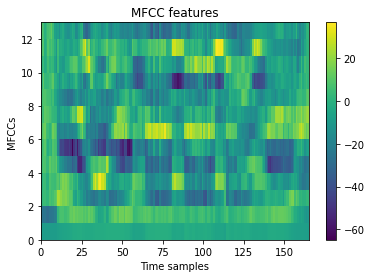

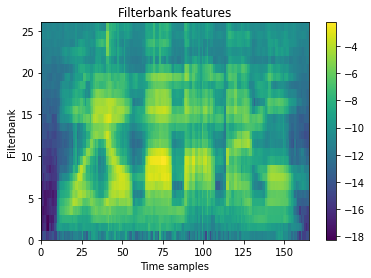

In [86]:
plt.figure()
plt.title("MFCC features")
plt.pcolormesh(np.transpose(mfcc_feat))
plt.xlabel("Time samples")
plt.ylabel("MFCCs")
plt.colorbar()

plt.figure()
plt.title("Filterbank features")
plt.pcolormesh(np.transpose(fbank_feat))
plt.xlabel("Time samples")
plt.ylabel("Filterbank")
plt.colorbar()

## Step 0. Pick extract of sound to analyze

Let's pick some part of the audio file to analyze. We also can normalize the amplitude with respect to the bit depth.

Text(0, 0.5, 'Normalized amplitude')

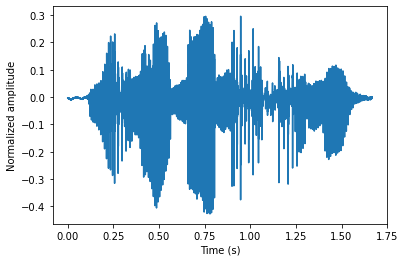

In [47]:
bit_depth = 16
sig = sig/((2**bit_depth)/2) # normalize signal amplitude for 16-bit

plt.figure()
t = np.arange(0, dur_sig, 1/fs) 
plt.plot(t,sig)
plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")

We can visually inspect the waveform and see which part of the waveform we want to analyze and then play that extract.

Text(0, 0.5, 'Normalized amplitude')

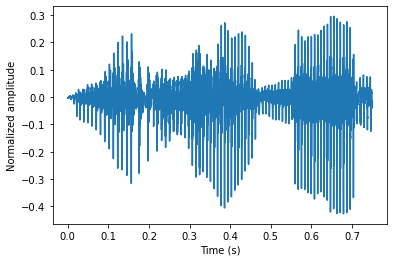

In [56]:
sig_extract = sig[int(0.1 * fs):int(0.85 * fs)]  

display(Audio(data=sig_extract, rate=fs))


dur_sig_extract = len(sig_extract) *1/fs 

plt.figure()
t = np.arange(0, dur_sig_extract, 1/fs) 
plt.plot(t,sig_extract)
plt.xlabel("Time (s)")
plt.ylabel("Normalized amplitude")

### Step 1. Pre-emphasis

For this step, we'll need to understand `python_speech_features.sigproc.framesig`, see [github repository code](https://github.com/jameslyons/python_speech_features/blob/master/python_speech_features/sigproc.py)

```python
def preemphasis(signal, coeff=0.95):
    """perform preemphasis on the input signal.
    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.95.
    :returns: the filtered signal.
    """
    return numpy.append(signal[0], signal[1:] - coeff * signal[:-1])

```

### Step 2. Frame the signal into short frames.

For this step, we'll need to understand `python_speech_features.sigproc.framesig`.

### Step 3. For each frame calculate the periodogram estimate of the power spectrum.

For this step, we'll need to understand `python_speech_features.sigproc.powspec`.

### Step 4. Apply the mel filterbank to the power spectra, sum the energy in each filter.

For this step, we'll need to understand `python_speech_features.base.fbank`. But first, let's take a closer look at the mel scale and mel filterbanks.

#### The mel scale
The mel scale was empirically determined by asking listeners to judge when they perceived a pure tone as having half the pitch of a reference tone, starting at 1000 Hz, with 1000 mels defined to be 1000 Hz as a first reference.

There are various formulas people have used to do conversion between mel and Hz. Some are given at [this webpage from Traunmüller](https://www2.ling.su.se/staff/hartmut/bark.htm#conv). See also [an Auditory.org e-mail thread discussion of the history of mel scale conversions](http://www.auditory.org/postings/2009/581.html). Which formula is used in the `python_speech_features` code?

#### Mel filter banks

The Mel filter bank is a set of overlapping triangular windows in the frequency domain whose centers and bandwidths are motivated by critical bands. Each filter has a response of 1 at the center frequency and then a response of 0 at the center frequency of its neighboring filters; then linear interpolation between 1 and 0 is used to get the "triangular" shape. 

***Can you plot the filterbank? Hint: see http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/***

### Step 5. Take the logarithm of all filterbank energies.

For this step, we'll need to understand `python_speech_features.base.logfbank`.

But first, let's also consider why we do a log transform. One auditorily-motivated reason is due to the power law relation between intensity (acoustic measure) and loudness (perceptual measure). Another reason is to decrease sensitivity to small variations in the input signal.


### Step 5. Take the DCT of the log filterbank energies.

For this step, we'll need to take a look at `scipy.sig.fftpack.dct`.

### Step 6. Keep DCT coefficients 2-13, discard the rest.

For this step, we'll need to understand `python_speech_features.base.lifter`.